In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [ ]:
# データセットの読み込み
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    header=None,
)
df.columns = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education-num",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "gender",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
    "native-country",
    "income",
]

In [ ]:
# 半角スペースの削除
cat_cols = df.select_dtypes(include=["object"]).columns

for col in cat_cols:
    df[col] = df[col].str.replace(" ", "")

In [ ]:
# レコードの絞り込み（United-Statesのみ）
df = df[df["native-country"] == "United-States"]
df = df.drop(columns=["native-country"], axis=1)
df.reset_index(drop=True, inplace=True)
df.shape

(29170, 14)

In [ ]:
# 正解ラベルの作成
df["income"] = df["income"].apply(lambda x: 1 if x == ">50K" else 0)

In [ ]:
# 特徴量と正解ラベルの分割
X = df.drop(columns=["income"], axis=1)
y = df["income"]

In [ ]:
# 学習データとテストデータの分割
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=0, stratify=y
)
print("X_trainの形状:", X_train.shape)
print("y_trainの形状:", y_train.shape)
print("X_testの形状:", X_test.shape)
print("y_testの形状:", y_test.shape)

X_trainの形状: (23336, 13)
y_trainの形状: (23336,)
X_testの形状: (5834, 13)
y_testの形状: (5834,)


In [ ]:
# カテゴリ変数のラベルエンコーディング
from sklearn.preprocessing import LabelEncoder

cat_cols = X.select_dtypes(include=["object"]).columns
for col in cat_cols:
    le = LabelEncoder()
    le.fit(X_train[col])
    X_train[col] = le.transform(X_train[col])
    X_test[col] = le.transform(X_test[col])

    X_train[col] = X_train[col].astype("category")
    X_test[col] = X_test[col].astype("category")

In [ ]:
# 学習データの20%を検証データに分割
X_tr, X_va, y_tr, y_va = train_test_split(
    X_train, y_train, test_size=0.2, shuffle=True, random_state=0, stratify=y_train
)
print("X_trの形状:", X_tr.shape)
print("y_trの形状:", y_tr.shape)
print("X_vaの形状:", X_va.shape)
print("y_vaの形状:", y_va.shape)

X_trの形状: (18668, 13)
y_trの形状: (18668,)
X_vaの形状: (4668, 13)
y_vaの形状: (4668,)


In [ ]:
import lightgbm as lgb

lgb_train = lgb.Dataset(X_tr, label=y_tr)
lgb_eval = lgb.Dataset(X_va, label=y_va, reference=lgb_train)

params = {"objective": "binary", "num_leaves": 5, "seed": 0, "verbose": -1}

# 誤差プロットの格納用データ
evals_result = {}

In [ ]:
# モデルの学習
model = lgb.train(
    params,
    lgb_train,
    num_boost_round=500,
    valid_sets=[lgb_train, lgb_eval],
    callbacks=[
        lgb.early_stopping(10),
        lgb.log_evaluation(100),
        lgb.record_evaluation(evals_result),
    ],
)

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.285093	valid_1's binary_logloss: 0.297689
[200]	training's binary_logloss: 0.271357	valid_1's binary_logloss: 0.291118
Early stopping, best iteration is:
[200]	training's binary_logloss: 0.271357	valid_1's binary_logloss: 0.291118


<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

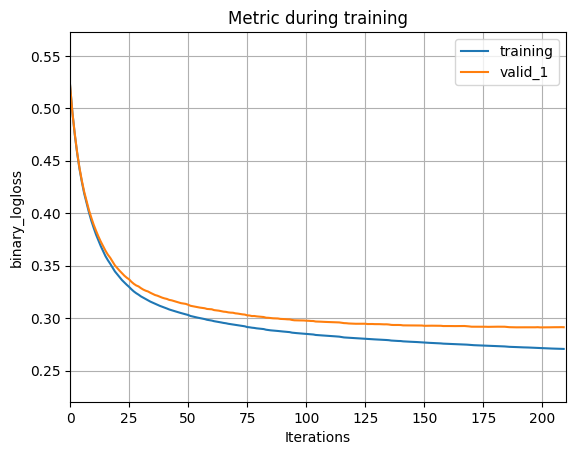

In [ ]:
# 学習データと検証データの誤差プロット
lgb.plot_metric(evals_result)

In [ ]:
# 学習が停止したブースティング回数
model.best_iteration

200